In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch import optim
from collections import OrderedDict
from time import time
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
import os
import copy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
data_dir = '/kaggle/input/satellite-image-classification'
train_dir = data_dir + '/data'

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.15 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [ ]:
torch.manual_seed(42)
model = models.resnet18(pretrained=True,weights=models.ResNet18_Weights)
model.name = "resnet18"
model

In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(model.fc.in_features, 256, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(256, 128, bias=True)),
                          ('fc3',nn.Linear(128,4, bias=True)),
                          ('output', nn.Softmax(dim=1))
                          ]))
model.fc = classifier

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
lossfun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [ ]:
model.to(device)

In [13]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [15]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train()
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = lossfun(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, lossfun)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [16]:
model_teacher = train(model,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 1.0166 |  Validation Loss: 0.8063 |  Validation Accuracy: 0.9596
Epoch: 1/5 |  Training Loss: 0.8157 |  Validation Loss: 0.7683 |  Validation Accuracy: 0.9788
Epoch: 2/5 |  Training Loss: 0.2870 |  Validation Loss: 0.7600 |  Validation Accuracy: 0.9871
Epoch: 2/5 |  Training Loss: 0.7869 |  Validation Loss: 0.7620 |  Validation Accuracy: 0.9847
Epoch: 2/5 |  Training Loss: 0.7691 |  Validation Loss: 0.7569 |  Validation Accuracy: 0.9882
Epoch: 3/5 |  Training Loss: 0.5677 |  Validation Loss: 0.7547 |  Validation Accuracy: 0.9906
Epoch: 3/5 |  Training Loss: 0.7774 |  Validation Loss: 0.7634 |  Validation Accuracy: 0.9800
Epoch: 4/5 |  Training Loss: 0.0787 |  Validation Loss: 0.7579 |  Validation Accuracy: 0.9847
Epoch: 4/5 |  Training Loss: 0.7602 |  Validation Loss: 0.7554 |  Validation Accuracy: 0.9871
Epoch: 4/5 |  Training Loss: 0.7699 |  Validation Loss: 0.7528 |  Validation Accuracy: 0.9918
Epoch: 5/5 |  Training 

In [17]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [18]:
labels,predictions = pred(model_teacher,testloader)

Time:  8.42046308517456
Accuracy achieved by the network on test images is: 98%


In [19]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


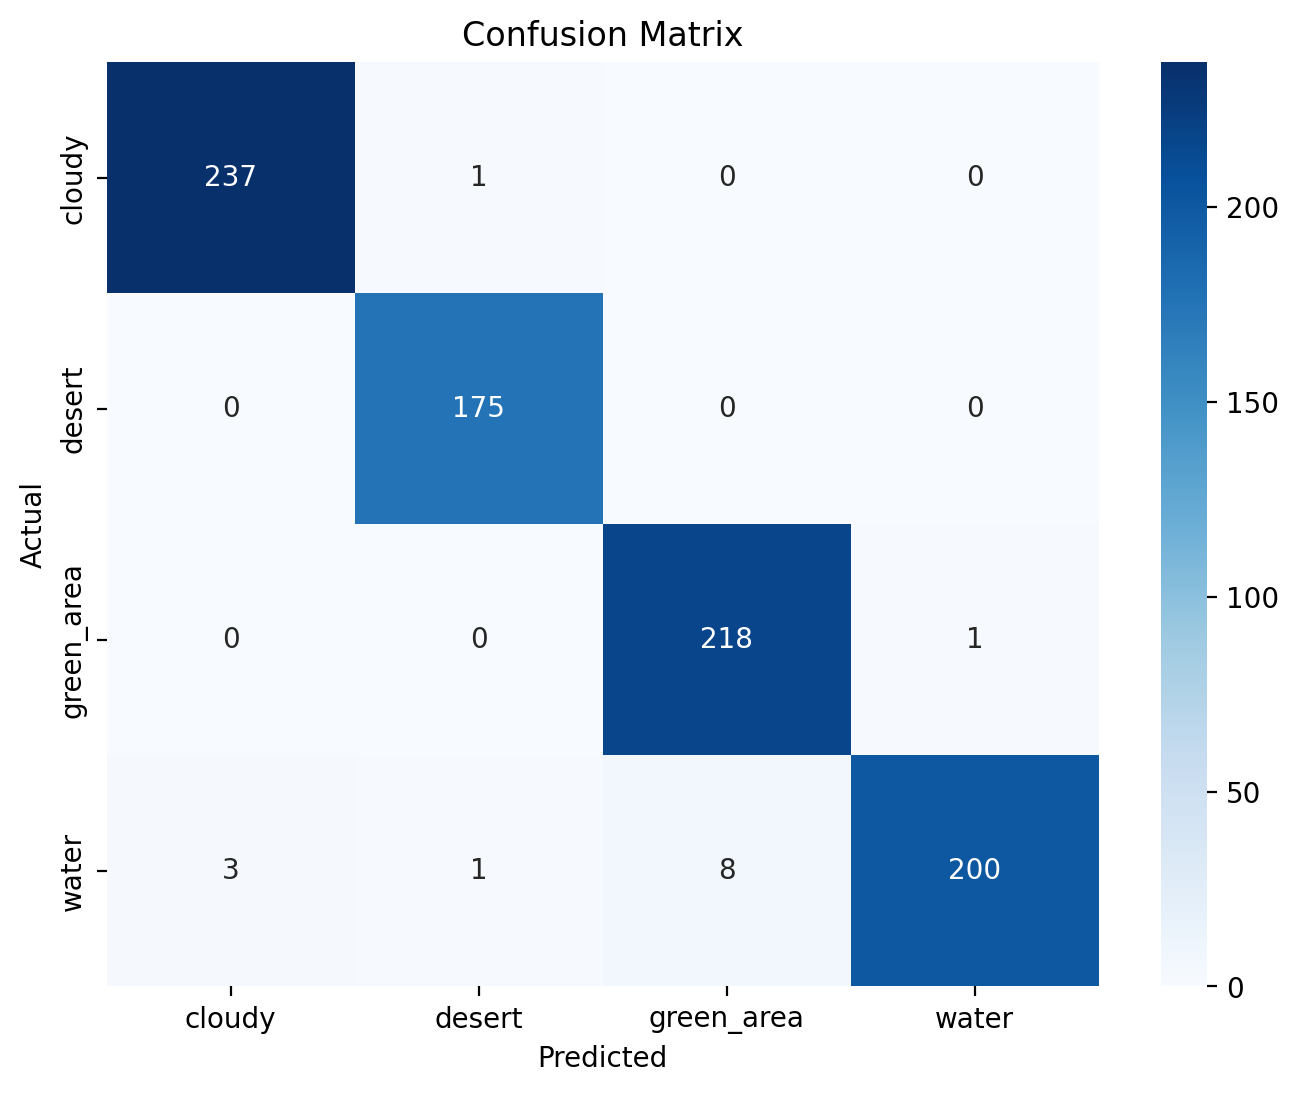

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       238
           1       0.99      1.00      0.99       175
           2       0.96      1.00      0.98       219
           3       1.00      0.94      0.97       212

    accuracy                           0.98       844
   macro avg       0.98      0.98      0.98       844
weighted avg       0.98      0.98      0.98       844



In [20]:
metrics(labels,predictions)

In [ ]:
torch.save(model.state_dict(),'resnet18_model.pth')

In [21]:
!pip install torchsummary

In [22]:
import torchsummary
print(torchsummary.summary(model.to(device),(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [24]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # try adding another conv2d layer
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(6272, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256,128),
            nn.Linear(128,4)
            #nn.Softmax(dim=1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x



In [26]:
torch.manual_seed(42)
m_student = Net().to(device)

In [ ]:
print(torchsummary.summary(m_student.to(device),(3,224,224)))

In [30]:
torch.manual_seed(42)
new_m_student = Net().to(device)

In [ ]:
# training without distillation
model_student = train(m_student,steps,print_every,30)
print('-----------------------------------------------------')
labels_m,predictions_m = pred(model_student,testloader)
metrics(labels_m,predictions_m)

In [31]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [32]:
train_knowledge_distillation(teacher=model_teacher, student=new_m_student, train_loader=trainloader, 
                             epochs=15, learning_rate=0.001, T=2, soft_target_loss_weight=0.25,
                             ce_loss_weight=0.75, device=device)

Epoch 1/15, Loss: 1.9382063316393503
Epoch 2/15, Loss: 1.829444148872472
Epoch 3/15, Loss: 1.8146159709254397
Epoch 4/15, Loss: 1.8115676384937913
Epoch 5/15, Loss: 1.8079203367233276
Epoch 6/15, Loss: 1.8050472630730159
Epoch 7/15, Loss: 1.802932837341405
Epoch 8/15, Loss: 1.7969823441927946
Epoch 9/15, Loss: 1.787748946419245
Epoch 10/15, Loss: 1.7891164339041408
Epoch 11/15, Loss: 1.786454218852369
Epoch 12/15, Loss: 1.7686647086203853
Epoch 13/15, Loss: 1.7741426244566711
Epoch 14/15, Loss: 1.7683337293093717
Epoch 15/15, Loss: 1.768390057962152


Time:  2.8745529651641846
Accuracy achieved by the network on test images is: 93%
Confusion Matrix:


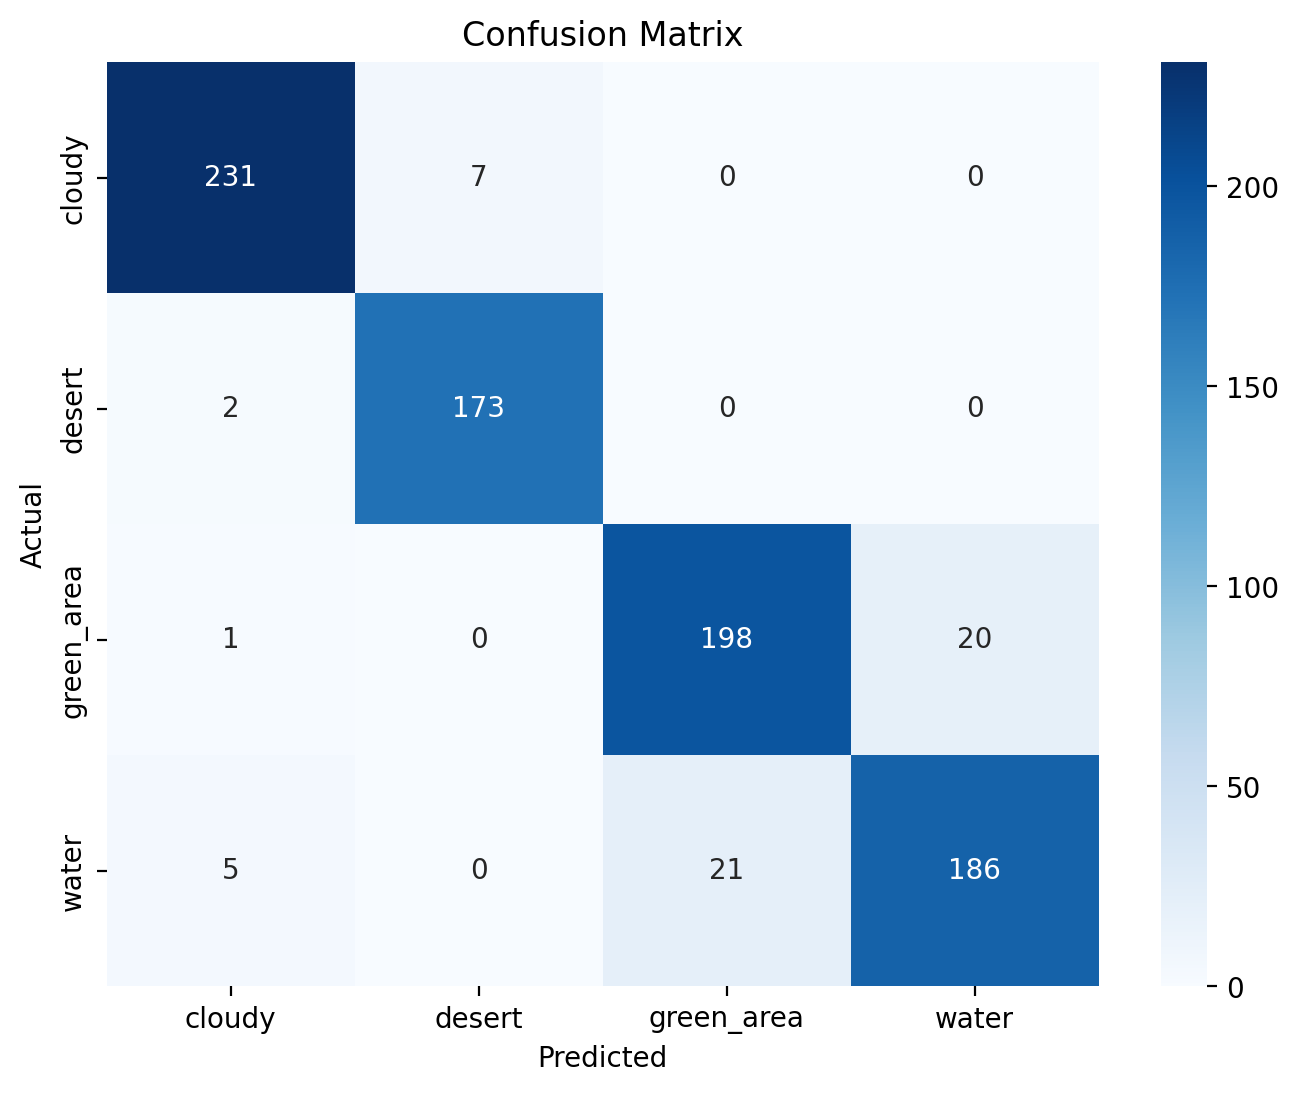

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       238
           1       0.96      0.99      0.97       175
           2       0.90      0.90      0.90       219
           3       0.90      0.88      0.89       212

    accuracy                           0.93       844
   macro avg       0.93      0.94      0.93       844
weighted avg       0.93      0.93      0.93       844



In [33]:
labels_m_new,predictions_m_new = pred(new_m_student,testloader)
metrics(labels_m_new,predictions_m_new)

In [34]:
total_params_deep = "{:,}".format(sum(p.numel() for p in model_teacher.parameters()))
print(f"Teacher parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in new_m_student.parameters()))
print(f"Student parameters: {total_params_light}")

Teacher parameters: 11,341,252
Student parameters: 1,662,076


In [47]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [48]:
print('Teacher : ',end='')
print_model_size(model_teacher)
print('Student : ',end='')
print_model_size(new_m_student)

Teacher : 45.44 MB
Student : 6.66 MB
